
# Credit Card Fraud Detection

The objective of this project is to create a machine learning model that successfully predicts whether or not a transaction is fraudulent or not. The goal is to achieve a 99% accuracy or above.

In [93]:
from statistics import linear_regression

#Loading our python libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [94]:
#Load in our dataset and read the top 8 columns
df = pd.read_csv('card_transdata_danush.csv')
df.head(8)

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0
5,5.586408,13.261073,0.064768,1.0,0.0,0.0,0.0,0.0
6,3.724019,0.956838,0.278465,1.0,0.0,0.0,1.0,0.0
7,4.848247,0.320735,1.273050,1.0,0.0,1.0,0.0,0.0


By just glancing at this it looks like we have an imbalanced dataset for our target variable(fraud). Lets double check below.

fraud
0.0    912597
1.0     87403
Name: count, dtype: int64
fraud
0.0    0.912597
1.0    0.087403
Name: proportion, dtype: float64


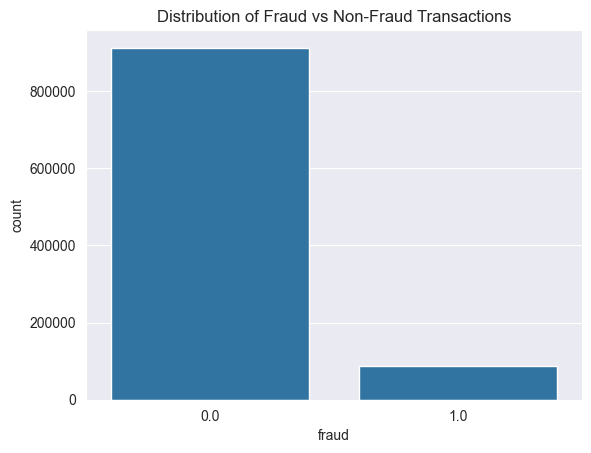

In [95]:
# Count of each class
print(df['fraud'].value_counts())
# Percentage of each class
print(df['fraud'].value_counts(normalize=True))

sns.countplot(x='fraud', data=df)
plt.title('Distribution of Fraud vs Non-Fraud Transactions')
plt.show()

Under 10% of our target variable is fraudulent. This means we can confirm that the dataset is imbalanced. This means that we can get a model that is over 90% accurate at guessing fraudulent vs nonfraudulent transaction just by saying nonfraudulent everytime. This is not what we want. We want a model that is accurate at predicting fraudulent transactions when they are in fact fraudulent.

To deal with this imbalance in our data we will undersample our transactions that our not fraudulent and create a new smaller dataset that has equal numbers of fraudulent and nonfraudulent transactions.

In [96]:
#Separate fraud and non-fraud parts of our dataset
fraud = df[df['fraud']==1]
non_fraud = df[df['fraud']==0]

#Create a smaller version of the non_fraud entries to match the number of fraudulent entries
non_fraud_reduced = non_fraud.sample(n=len(fraud), random_state=42)

#Combine non_fraud_reduced with fraud
df_balanced = pd.concat([fraud, non_fraud_reduced])
#Shuffle the dataset so that the entries are randomized
df_balanced = df_balanced.sample(frac=1,random_state=42).reset_index(drop=True)

In [97]:
df_balanced.head(10)

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,8.668889,0.725783,11.439120,1.0,1.0,0.0,1.0,1.0
1,28.501728,1.629492,11.710914,1.0,0.0,0.0,1.0,1.0
2,15.161964,0.027713,0.914625,1.0,0.0,0.0,0.0,0.0
3,3.294325,0.700697,1.829264,1.0,0.0,0.0,0.0,0.0
4,76.742356,0.321263,0.177628,1.0,1.0,0.0,0.0,0.0
5,44.286714,0.092786,5.389702,1.0,0.0,0.0,1.0,1.0
6,46.924529,17.738667,6.668987,1.0,1.0,0.0,0.0,0.0
7,17.007461,3.380928,12.311901,1.0,0.0,0.0,1.0,1.0
8,19.059266,0.241115,1.961128,1.0,0.0,0.0,0.0,0.0
9,6.954744,2.592445,8.245415,1.0,0.0,0.0,1.0,1.0


fraud
1.0    87403
0.0    87403
Name: count, dtype: int64
fraud
1.0    0.5
0.0    0.5
Name: proportion, dtype: float64


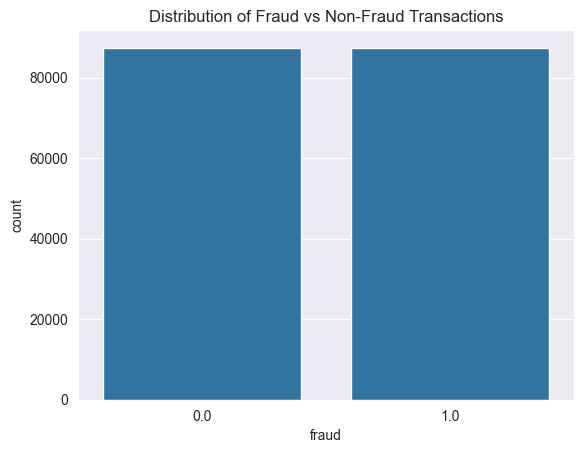

In [98]:
# Count of each class
print(df_balanced['fraud'].value_counts())
# Percentage of each class
print(df_balanced['fraud'].value_counts(normalize=True))

#palette = {"0": "blue", "1": "red"}

sns.countplot(x='fraud', data=df_balanced)
plt.title('Distribution of Fraud vs Non-Fraud Transactions')
plt.show()

Now as you can see above we have an equal number of fraudulent and non-fraudulent transactions in our new dataset. The downside of this is that we have reduced the total number of entries in our dataset from 1,000,000 to 87403.

In [99]:
#Check for duplicates
# Check total number of duplicate rows
duplicates_count = df_balanced.duplicated().sum()
print(f"Number of duplicate rows: {duplicates_count}")

Number of duplicate rows: 0


# Check total number of duplicate rows
duplicates_count = df_balanced.duplicated().sum()
print(f"Number of duplicate rows: {duplicates_count}")## Defining our training data

In [100]:
#First we will separate our feature and target
X = df_balanced.drop('fraud', axis=1)
y = df_balanced['fraud']

#Now we'll use train test split to separate our entries into 80% training and 20% testing data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, stratify=y)


First we will train a classification model with logistic regression to establish a baseline model before trying more advanced techniques like Gradient Boosting

In [101]:
#Scale the Features(Logistic regression benefits from this)
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Train the Logistic Regression Model
logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train)

#Making Predictions
y_pred = logreg.predict(X_test_scaled)
y_proba = logreg.predict_proba(X_test_scaled)[:, 1]

Now Lets Evaluate the model

In [102]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

Confusion Matrix:
 [[16349  1132]
 [  896 16585]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.94      0.94     17481
         1.0       0.94      0.95      0.94     17481

    accuracy                           0.94     34962
   macro avg       0.94      0.94      0.94     34962
weighted avg       0.94      0.94      0.94     34962

ROC AUC Score: 0.9791361504388294


The F1-score of this logistic regression model is 0.94, which indicates a strong balance between precision (the proportion of predicted fraud cases that are actually fraud) and recall (the proportion of actual fraud cases that were correctly identified).

In other words, the model is correctly detecting the majority of fraudulent transactions while minimizing false alarms. This makes it a reliable model for fraud detection in this dataset.

## Now lets try Gradient Boosting to see if we can get some better results.

In [103]:
#First we will separate our feature and target
X = df_balanced.drop('fraud', axis=1)
y = df_balanced['fraud']

#Now we'll use train test split to separate our entries into 80% training and 20% testing data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, stratify=y)

# We've already defined our train and test sets

from sklearn.ensemble import GradientBoostingClassifier

# Initialize model
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_features=None,
    max_leaf_nodes=None,
    random_state=41
)

# Train the model
gb_model.fit(X_train, y_train)

# Make predictions
y_pred = gb_model.predict(X_test)
y_proba = gb_model.predict_proba(X_test)[:, 1]  # probability of class 1

In [104]:
#Evaluate our Gradient Boosting Model
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}\n")
print(f"Classification Report:\n{classification_report(y_test, y_pred)}\n")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")


Confusion Matrix:
[[17416    65]
 [    0 17481]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     17481
         1.0       1.00      1.00      1.00     17481

    accuracy                           1.00     34962
   macro avg       1.00      1.00      1.00     34962
weighted avg       1.00      1.00      1.00     34962


ROC AUC Score: 1.0000


100% Acurracy is good but concerning. Lets double check with more decimals below to make sure this is right.

In [105]:

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{cm}\n")

# Classification Report with 10 decimals
report_dict = classification_report(y_test, y_pred, output_dict=True)
print("Classification Report:")
for cls, metrics in report_dict.items():
    if isinstance(metrics, dict):
        print(f"{cls}:")
        for metric_name, value in metrics.items():
            print(f"  {metric_name}: {value:.10f}")
    else:  # For 'accuracy'
        print(f"{cls}: {metrics:.10f}")

# ROC AUC Score with 10 decimals
roc_auc = roc_auc_score(y_test, y_proba)
print(f"\nROC AUC Score: {roc_auc:.10f}")

# Optional: individual metrics also formatted
print("\nIndividual Metrics:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.10f}")
print(f"Precision: {precision_score(y_test, y_pred):.10f}")
print(f"Recall:    {recall_score(y_test, y_pred):.10f}")
print(f"F1-score:  {f1_score(y_test, y_pred):.10f}")

Confusion Matrix:
[[17416    65]
 [    0 17481]]

Classification Report:
0.0:
  precision: 1.0000000000
  recall: 0.9962816772
  f1-score: 0.9981373757
  support: 17481.0000000000
1.0:
  precision: 0.9962954520
  recall: 1.0000000000
  f1-score: 0.9981442887
  support: 17481.0000000000
accuracy: 0.9981408386
macro avg:
  precision: 0.9981477260
  recall: 0.9981408386
  f1-score: 0.9981408322
  support: 34962.0000000000
weighted avg:
  precision: 0.9981477260
  recall: 0.9981408386
  f1-score: 0.9981408322
  support: 34962.0000000000

ROC AUC Score: 0.9999979449

Individual Metrics:
Accuracy:  0.9981408386
Precision: 0.9962954520
Recall:    1.0000000000
F1-score:  0.9981442887


## Conclusion
We have developed a Gradient Boosted model that achieves 99% accuracy in predicting credit card fraud, compared to a benchmark logistic regression model with an F1 score of 0.95 on the same dataset. When considering deployment in a real-time system, the tradeoff between computational cost and improved accuracy must be evaluated. Given the high stakes associated with credit card fraud, the additional accuracy provided by the Gradient Boosted model is likely worthwhile, even if it requires more computational resources.